In [106]:
%reload_ext autoreload
%autoreload 2

# What jobs?

In [107]:
from Scratch import metadata_loader


DEVICE = "ibm_sherbrooke"
LOGICAL = str(0)
XBASIS = False
ROUNDS = 30

state = "X" if XBASIS else "Z"
state += LOGICAL
print(f"state = {state}")

# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md[md["descr"] == 'subset RepCodes']
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]
md = md[md["xbasis"] == XBASIS]
md = md[md["rounds"] == ROUNDS]

md = md[:20]
print("shape:", md.shape)
md[:2]

state = Z0
shape: (20, 18)


,creation_date,notebook_name,backend_name,job_id,tags,meas_level,shots,num_qubits,job_status,execution_date,code,distance,rounds,logical,descr,resets,xbasis,path_info
3139,2024-03-15 23:22:42.340000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqtcmchtxzj0008xz2dg,"[Subset 51, 30 rounds, 0 log, xbasis=False]",1.0,2498.0,NaN,JobStatus.DONE,2024-03-16 00:08:20.466074+01:00,RepetitionCodeCircuit,51,30,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.008453046741093, 'min_ga..."
3138,2024-03-15 23:22:38.205000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqtcmb9txzj0008xz2d0,"[Subset 51, 30 rounds, 0 log, xbasis=False]",1.0,2498.0,NaN,JobStatus.DONE,2024-03-16 00:07:51.044942+01:00,RepetitionCodeCircuit,51,30,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.008453046741093, 'min_ga..."


# Load the data

In [108]:
import json

file_name = '../results/' + state + '_' + str(ROUNDS) +'.json'

with open(file_name, 'r') as f:
    decoding_data = json.load(f)

print(len(decoding_data.keys()))

20


# Get the cummulative error dict

In [110]:
import numpy as np

distances = list(range(7, md["distance"].values[0] + 1, 4))
err_rate_dict = {d: [{}, 0] for d in distances}

for index, row in md.iterrows():
    decoding_results = decoding_data[row["job_id"]]
    shots = row["shots"]
    for result in decoding_results:
        d_new = int(result["d_new"])
        decoding = result["decoding"]
        num_errors = result["num_errors"]
        if decoding not in err_rate_dict[d_new][0]:
            err_rate_dict[d_new][0][decoding] = []
        err_rate_dict[d_new][0][decoding].append(num_errors)
        err_rate_dict[d_new][1] += shots/2 # bcs twice for hard and kde


print(err_rate_dict)

mean_err_rate_dict = {}
for d in distances:
    mean_err_rate_dict[d] = {}
    for decoding in err_rate_dict[d][0]:
        mean_err_rate_dict[d][decoding] = np.sum(err_rate_dict[d][0][decoding]) 
    mean_err_rate_dict[d]["shots"] = err_rate_dict[d][1]

print(mean_err_rate_dict)


{7: [{'kde': [342.3333333333333, 318.3333333333333, 356.77777777777777, 340.0, 315.77777777777777, 338.3333333333333, 354.6666666666667, 319.0, 337.44444444444446, 360.6666666666667, 338.8888888888889, 336.22222222222223, 349.77777777777777, 356.1111111111111, 335.1111111111111, 355.0, 375.8888888888889, 359.6666666666667, 342.77777777777777, 370.22222222222223], 'hard': [369.44444444444446, 343.77777777777777, 368.77777777777777, 350.22222222222223, 336.77777777777777, 356.44444444444446, 380.0, 336.77777777777777, 360.0, 370.6666666666667, 349.55555555555554, 353.0, 368.55555555555554, 375.8888888888889, 349.44444444444446, 384.22222222222223, 388.55555555555554, 372.55555555555554, 352.77777777777777, 387.55555555555554]}, 49960.0], 11: [{'kde': [160.6, 154.8, 172.4, 169.6, 145.4, 165.4, 169.4, 148.8, 152.6, 166.4, 151.6, 163.0, 165.0, 158.6, 159.4, 177.6, 176.8, 167.4, 154.0, 179.4], 'hard': [184.4, 172.4, 191.4, 175.8, 166.4, 183.8, 172.0, 159.6, 158.4, 178.2, 160.0, 172.4, 172.6,

# Plot

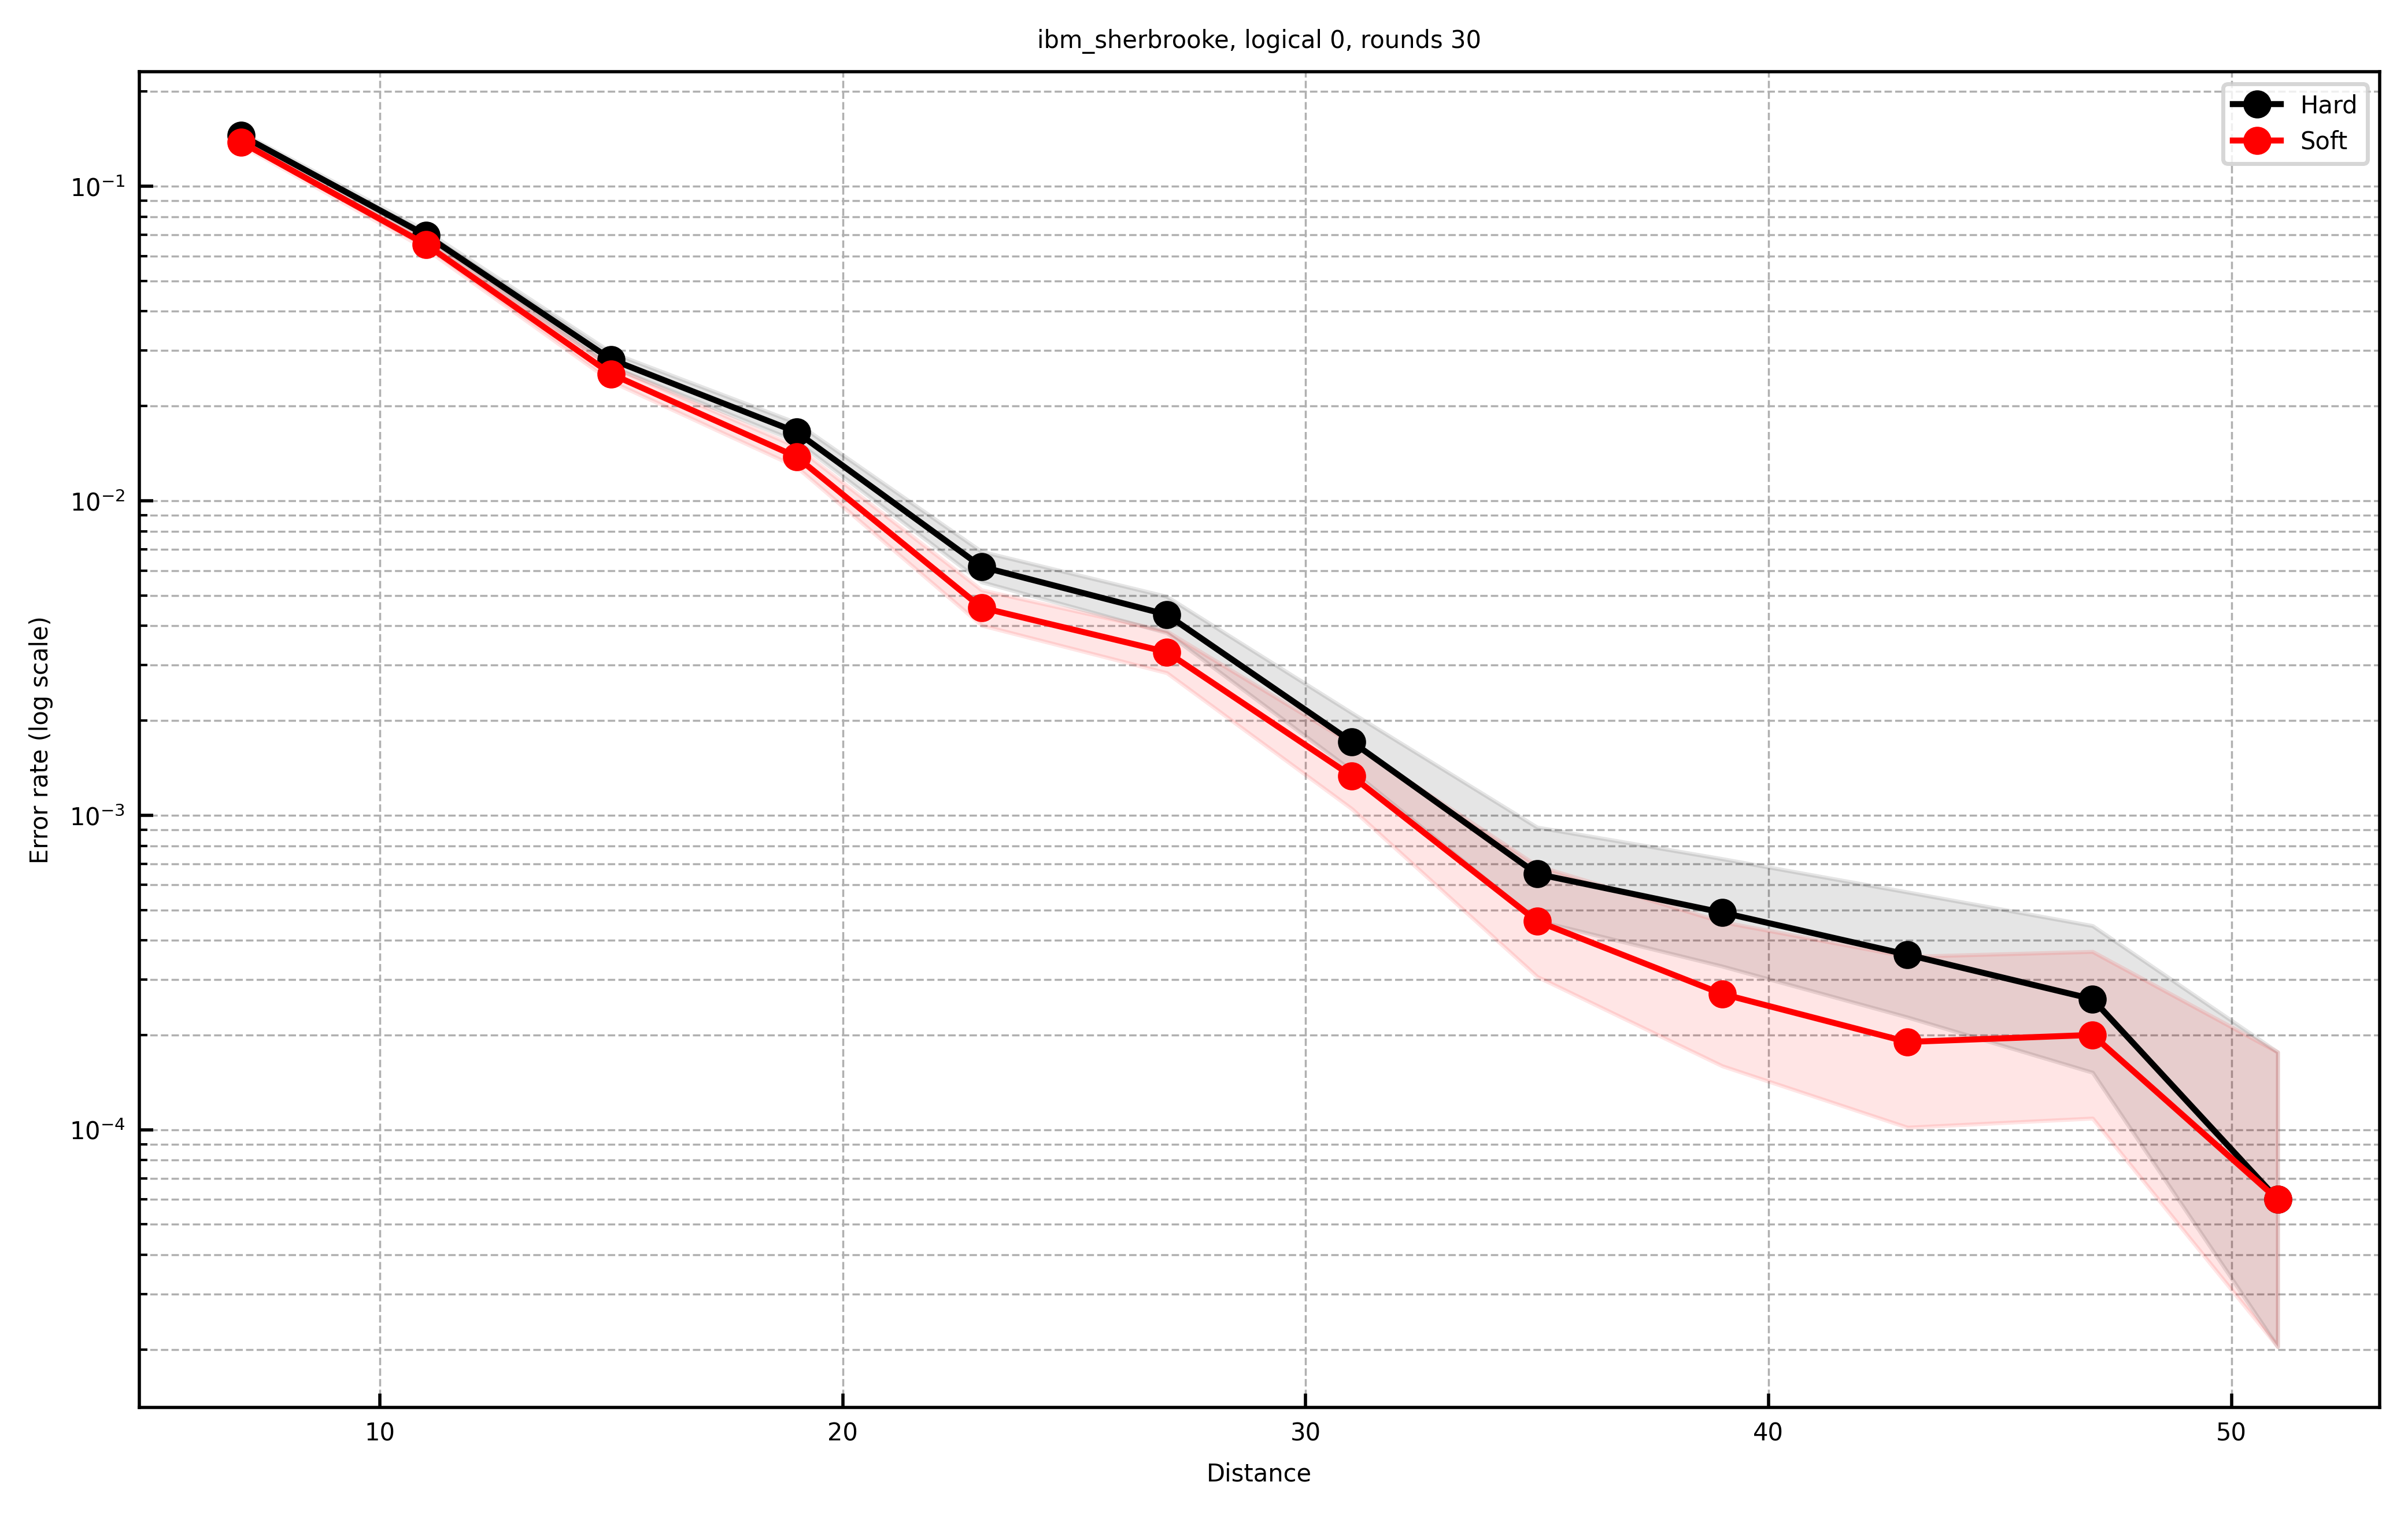

In [111]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

FIGURE_WIDTH_1COL = 3.404  # For PRX style, change for according to journal
FIGURE_WIDTH_2COL = 7.057  # For PRX style, change for according to journal
FIGURE_HEIGHT_1COL_GR = FIGURE_WIDTH_1COL*2/(1 + np.sqrt(5))*1.1
FIGURE_HEIGHT_2COL_GR = FIGURE_WIDTH_2COL*2/(1 + np.sqrt(5))*1.1

font_size = 6 # For PRX style, change for according to journal

plt.rcParams.update({
    'font.size'           : font_size,  
    'figure.titlesize'    : 'medium',
    'figure.dpi'          : 500,
    'figure.figsize'      : (FIGURE_WIDTH_1COL, FIGURE_HEIGHT_1COL_GR),
    'axes.titlesize'      : 'medium',
    'axes.axisbelow'      : True,
    'xtick.direction'     : 'in',
    'xtick.labelsize'     : 'small',
    'ytick.direction'     : 'in',
    'ytick.labelsize'     : 'small',
    'image.interpolation' : 'none',
    'legend.fontsize'     : font_size,
    'axes.labelsize'      : font_size,
    'axes.titlesize'      : font_size,
    'xtick.labelsize'     : font_size,
    'ytick.labelsize'     : font_size,
})


# Wilson score interval function
def wilson_score_interval(p, n, z=1.96):  # Using z=1.96 for a 95% confidence interval
    denominator = 1 + z**2 / n
    term = z * np.sqrt(p * (1 - p) / n + z**2 / (4 * n**2))
    lower = (p + z**2 / (2 * n) - term) / denominator
    upper = (p + z**2 / (2 * n) + term) / denominator
    return max(lower, 0), min(upper, 1)

err_rates_hard = []
err_rates_soft = []
hard_lowers = []
hard_uppers = []
soft_lowers = []
soft_uppers = []

for d in distances:
    # For 'hard' decoding
    p_hard = mean_err_rate_dict[d]["hard"]/mean_err_rate_dict[d]["shots"]
    err_rates_hard.append(p_hard)
    lower_hard, upper_hard = wilson_score_interval(p_hard, mean_err_rate_dict[d]["shots"])
    hard_lowers.append(lower_hard)
    hard_uppers.append(upper_hard)

    # For 'soft' decoding
    p_soft = mean_err_rate_dict[d]["kde"]/mean_err_rate_dict[d]["shots"]
    err_rates_soft.append(p_soft)
    lower_soft, upper_soft = wilson_score_interval(p_soft, mean_err_rate_dict[d]["shots"])
    soft_lowers.append(lower_soft)
    soft_uppers.append(upper_soft)

plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Plotting error rates for 'hard' and 'soft', including confidence intervals
plt.plot(distances, err_rates_hard, label="Hard", marker='o', color='black')
plt.fill_between(distances, hard_lowers, hard_uppers, color='black', alpha=0.1)
plt.plot(distances, err_rates_soft, label="Soft", marker='o', color='red')
plt.fill_between(distances, soft_lowers, soft_uppers, color='red', alpha=0.1)

plt.yscale("log")
plt.ylabel('Error rate (log scale)')
plt.xlabel('Distance')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.title(f"{DEVICE}, logical {LOGICAL}, rounds {ROUNDS}")

plt.show()

In [112]:
# zip the distances and the error rates together
data = list(zip(distances, err_rates_hard, err_rates_soft))
data

[(7, 0.14521617293835065, 0.13817053642914334),
 (11, 0.06981184947958366, 0.06521617293835069),
 (15, 0.02811749399519616, 0.02527021617293835),
 (19, 0.016539898585535097, 0.013797704830531093),
 (23, 0.006164931945556445, 0.004570322925006672),
 (27, 0.004343474779823859, 0.0033026421136909527),
 (31, 0.001711369095276221, 0.0013310648518815053),
 (35, 0.0006505204163330665, 0.0004603682946357086),
 (39, 0.0004903923138510808, 0.0002702161729383507),
 (43, 0.0003602882305844676, 0.00019015212169735788),
 (47, 0.0002602081665332266, 0.00020016012810248197),
 (51, 6.0048038430744594e-05, 6.0048038430744594e-05)]